In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
print( os.getcwd() )

/Users/austinclime/vs_code_projects/vix_approx/vix_approx_research/VIX_SKEW_replication


In [8]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pyarrow as pa
#import pyarrow.parquet as pq
#import pyarrow.csv as pv

from io import StringIO
from datetime import timedelta
import pytz
import datetime

#import pandas_datareader.data as web
import pandas_market_calendars as mcal
from scipy.interpolate import CubicSpline, interp1d

In [16]:
path='https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv'
vix_hist=pd.read_csv(path,index_col='DATE')
vix_hist.index = pd.to_datetime(vix_hist.index)
vix_hist.index = vix_hist.index.strftime('%Y-%m-%d')
display(vix_hist.head(2))
path='https://cdn.cboe.com/api/global/us_indices/daily_prices/SKEW_History.csv'
skew_hist=pd.read_csv(path,index_col='DATE')
skew_hist.index = pd.to_datetime(skew_hist.index)
skew_hist.index = skew_hist.index.strftime('%Y-%m-%d')
display(skew_hist.head(2))

,OPEN,HIGH,LOW,CLOSE
DATE,,,,
1990-01-02,17.24,17.24,17.24,17.24
1990-01-03,18.19,18.19,18.19,18.19


,SKEW
DATE,
1990-01-02,126.09
1990-01-03,123.34


In [17]:
vixmo_data_df=pd.read_csv('options_vixmo_data.csv')
#vixmo_data_df['CALCULATION_TIME']=pd.to_datetime(vixmo_data_df['CALCULATION_TIME'])
vixmo_data_df['CALCULATION_DATE']=vixmo_data_df.CALCULATION_TIME.str.split(' ').str[0]
#vixmo_data_df.groupby(['CALCULATION_DATE','TERM'])
skew_vixmo_df=pd.read_csv('skew_calc_vixmo_data.csv')

skew_vixmo_df.rename(columns={'trade_date':'CALCULATION_DATE'},inplace=True)
skew_vixmo_df.set_index('CALCULATION_DATE',inplace=True)
skew_vixmo_df.index = pd.to_datetime(skew_vixmo_df.index)
skew_vixmo_df.index = skew_vixmo_df.index.strftime('%Y-%m-%d')

/var/folders/nr/239fpjgn5zg829rq2drl_2kw0000gn/T/ipykernel_27116/3321116148.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  skew_vixmo_df.index = pd.to_datetime(skew_vixmo_df.index)


In [28]:
def index_computation(truncation_condition=None):

    def skew_weights_1(slice):
        mins_30_days=30*60*24
        slice1=slice[slice.TERM=='near']
        slice2=slice[slice.TERM=='next']
        w=(slice2.MIN_TO_EXPIRE.unique()[0]-mins_30_days)
        w/=(slice2.MIN_TO_EXPIRE.unique()[0]-slice1.MIN_TO_EXPIRE.unique()[0])
        return [w,1-w]

    def portfolio_constructors(slice):
        F=slice.FORWARD_PRICE.unique()[0]
        K0=slice.K0_SELECTION.unique()[0]
        calls=slice[slice.STRIKE_PRICE>K0]
        puts=slice[slice.STRIKE_PRICE<K0]
        pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                                'CALL_PUT_FLAG':'P/C Avg', #put-call average
                                'midprice':slice[(slice.STRIKE_PRICE==K0)]['midprice'].mean(),
                                'INTEREST_RATE':slice.INTEREST_RATE,
                                'YEARS_TO_EXPIRE':slice.YEARS_TO_EXPIRE} ).head(1)
        opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
        #opt_portfolio=pd.concat([puts,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
        opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
        opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
        opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']
        
        #Truncating the portfolio
        opt_portfolio['moneyness_pct']=F/opt_portfolio['STRIKE_PRICE']-1
        opt_portfolio['z_moneyness']=(opt_portfolio['moneyness_pct']-opt_portfolio['moneyness_pct'].mean()) / opt_portfolio['moneyness_pct'].std() 
        #opt_portfolio=opt_portfolio[ (abs(opt_portfolio.z_moneyness)<=2) ]
        #opt_portfolio=opt_portfolio[ (opt_portfolio.z_moneyness<=2) ]
        #opt_portfolio=opt_portfolio[ abs(opt_portfolio.moneyness_pct<=0.1) ]
        if truncation_condition:
            opt_portfolio=opt_portfolio.query(truncation_condition)
        #display(opt_portfolio)
        #print(5/0)

        r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
        
        #CBOE SKEW
        e1=-(1+np.log(F/K0)-(F/K0))
        e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
        e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
        p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
        p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2
        
        P1=( np.exp(r*t)*(opt_portfolio.midprice*p1_option_weight) ).sum()
        P1+=e1
        P2=( np.exp(r*t)*(opt_portfolio.midprice*p2_option_weight) ).sum()
        P2+=e2
        P3=( np.exp(r*t)*(opt_portfolio.midprice*p3_option_weight) ).sum()
        P3+=e3
        S=P3-3*P1*P2+2*P1**3
        S/=(P2-P1**2)**(3/2)
        
        #METHOD2
        sigma=np.sqrt(P2-P1**2)#**0.5
        S_method2=6/sigma**3 * (np.exp(-P1-0.5*sigma**2)-1)
        #display(opt_portfolio.iloc[277-3:277+3])
        #print(5/0)
        #Carr-Madan
        
        #METHOD3
        #"""
        correction_term=(1/t)*(F/K0-1)**2
        VIX_opt_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        SVIX_opt_weight=2*opt_portfolio.dK/(F**2)
        VIX_square=( np.exp(r*t)*(opt_portfolio.midprice*VIX_opt_weight) ).sum()
        SVIX_square=( np.exp(r*t)*(opt_portfolio.midprice*SVIX_opt_weight) ).sum()
        #VIX_square+=correction_term
        #SVIX_square+=correction_term
        sigma=np.sqrt(P2-P1**2)#**0.5
        S_method3=3/2*(SVIX_square-VIX_square)/ sigma**3#+3/2*np.sqrt(VIX_square)
        #"""
        #COMPRIMISE SKEW

        #METHOD 4
        MartinSKEW_opt_weight=6*(opt_portfolio.STRIKE_PRICE-F)*opt_portfolio.dK/(F**3)
        MartinSKEW_opt_weight/=sigma**3
        S_method4=( np.exp(r*t)*(opt_portfolio.midprice*MartinSKEW_opt_weight) ).sum()
        return [S,S_method2,S_method3,VIX_square,SVIX_square,P1,P2,S_method4] #.unique()[0]

    term_rep_df=pd.DataFrame(vixmo_data_df.groupby(['CALCULATION_DATE','TERM']).apply(portfolio_constructors),columns=['Replicates'])
    term_rep_df['S_rep']=term_rep_df['Replicates'].apply(lambda x:x[0])
    term_rep_df['S_method2']=term_rep_df['Replicates'].apply(lambda x:x[1])
    term_rep_df['S_method3']=term_rep_df['Replicates'].apply(lambda x:x[2])
    term_rep_df['VIX^2']=term_rep_df['Replicates'].apply(lambda x:x[3])
    term_rep_df['SVIX^2']=term_rep_df['Replicates'].apply(lambda x:x[4])
    term_rep_df['P1']=term_rep_df['Replicates'].apply(lambda x:x[5])
    term_rep_df['P2']=term_rep_df['Replicates'].apply(lambda x:x[6])
    term_rep_df['S_method4']=term_rep_df['Replicates'].apply(lambda x:x[7])
    term_rep_df.drop(['Replicates'],axis=1,inplace=True)
    term_rep_df

    w_rep=pd.DataFrame( vixmo_data_df.groupby(['CALCULATION_DATE']).apply(skew_weights_1) ,columns=['w'])
    w_rep['TERM']=[ ['near','next'] for i in w_rep.index]
    w_rep=w_rep.explode(['TERM','w'])
    w_rep.set_index('TERM', append=True, inplace=True)
    SKEW_rep_1=w_rep.join(term_rep_df,how='inner')
    SKEW_rep_1['weighted_S']=SKEW_rep_1['S_rep']*SKEW_rep_1['w']
    SKEW_rep_1=100-10*SKEW_rep_1.groupby(SKEW_rep_1.index.get_level_values(0))['weighted_S'].sum()
    SKEW_check_1=skew_vixmo_df['skew_level']-SKEW_rep_1
    #print('SKEW accuracy check')
    #display(SKEW_check_1[abs(SKEW_check_1)>= (10**-7) ])

    SKEW_rep_2=w_rep.join(term_rep_df,how='inner')
    SKEW_rep_2['weighted_S']=SKEW_rep_2['S_rep']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_S_method2']=SKEW_rep_2['S_method2']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_S_method3']=SKEW_rep_2['S_method3']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_S_method4']=SKEW_rep_2['S_method4']*SKEW_rep_2['w']
    #taking away 100-10 scaling
    #SKEW_rep_2=100-10*SKEW_rep_2.groupby(SKEW_rep_2.index.get_level_values(0))[['weighted_S','weighted_S_method2','weighted_S_method3']].sum()
    SKEW_rep_2=SKEW_rep_2.groupby(SKEW_rep_2.index.get_level_values(0))[['weighted_S','weighted_S_method2','weighted_S_method3','weighted_S_method4']].sum()
    SKEW_rep_2.rename(columns={'weighted_S':'CBOE_SKEW',
                            'weighted_S_method2':'SKEW_method2',
                            'weighted_S_method3':'SKEW_method3',
                            'weighted_S_method4':'SKEW_method4'},inplace=True)
    SKEW_rep_2[['CBOE_SKEW_chg','SKEW_method2_chg','SKEW_method3_chg','SKEW_method4_chg']]=SKEW_rep_2/SKEW_rep_2.shift(1)-1
    SKEW_rep_2#.to_csv('SKEW_formula_replciates.csv')

    #cboe_df=pd.DataFrame(vixmo_data_df.groupby(['CALCULATION_DATE','TERM'])[['P1','P2','P3','S']].mean())
    #cboe_df.columns=[i+'_CBOE' for i in cboe_df.columns]
    #cboe_df

    #merged_df=term_rep_df.join(cboe_df,how='inner')
    #merged_df['P1_error']=abs(merged_df['P1_UMD']-merged_df['P1_CBOE'])
    #merged_df['P2_error']=abs(merged_df['P2_UMD']-merged_df['P2_CBOE'])
    #merged_df['P3_error']=abs(merged_df['P3_UMD']-merged_df['P3_CBOE'])
    #merged_df['S_error']=abs(merged_df['S_rep']-merged_df['S_CBOE'])
    #merged_df#.to_csv('VIXMO_Replication_UMD.csv')
    #merged_df[['P1_error','P2_error','P3_error','S_error']].describe()

    #term_rep_df
    return SKEW_rep_2,term_rep_df,w_rep

SKEW_rep_2,term_rep_df,w_rep=index_computation(truncation_condition=None)
#cond='abs(moneyness_pct<=0.1)'
#cond='abs(moneyness_pct<=0.15)'
#display( index_computation(truncation_condition=cond) )

In [40]:
skew_correlation=pd.DataFrame.from_dict({'No_Truncation':[0*i for i in range(2,5+1)],
                        '10%_OOM_Truncation':[0*i for i in range(2,5+1)],
                        '15%_OOM_Truncation':[0*i for i in range(2,5+1)]},
                        orient='index',columns=['CBOE']+['Method'+str(i) for i in range(2,4+1)])

skew_correlation

conditions=[None,'abs(moneyness_pct<=0.1)','abs(moneyness_pct<=0.15)']
counter=0
for condition in conditions:
    SKEW_rep_2,term_rep_df,w_rep=index_computation(truncation_condition=condition)
    skew_correlation.iloc[counter,:]=SKEW_rep_2.corr().iloc[0,:4]
    counter+=1
    

Text(0.5, 1.0, 'Correlation with CBOE SKEW')

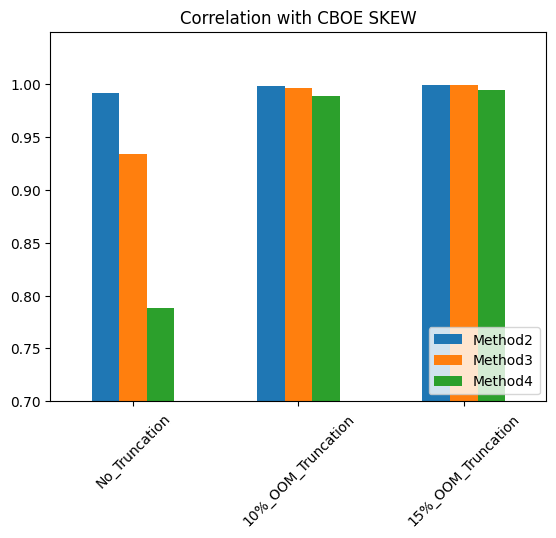

In [67]:
skew_correlation.iloc[:,1:]
ax=skew_correlation.iloc[:,1:].plot.bar(rot=45)
ax.legend(loc=4)
ax.set_ylim(0.7,None)
ax.set_title('Correlation with CBOE SKEW')


In [29]:
display( SKEW_rep_2.corr().iloc[:4,:4] )
display( SKEW_rep_2.corr().iloc[-4:,-4:] )

,CBOE_SKEW,SKEW_method2,SKEW_method3,SKEW_method4
CBOE_SKEW,1.000000,0.991714,0.933887,0.788163
SKEW_method2,0.991714,1.000000,0.971660,0.858146
SKEW_method3,0.933887,0.971660,1.000000,0.954398
SKEW_method4,0.788163,0.858146,0.954398,1.000000


,CBOE_SKEW_chg,SKEW_method2_chg,SKEW_method3_chg,SKEW_method4_chg
CBOE_SKEW_chg,1.000000,0.985519,0.854128,0.485525
SKEW_method2_chg,0.985519,1.000000,0.927057,0.608903
SKEW_method3_chg,0.854128,0.927057,1.000000,0.854616
SKEW_method4_chg,0.485525,0.608903,0.854616,1.000000


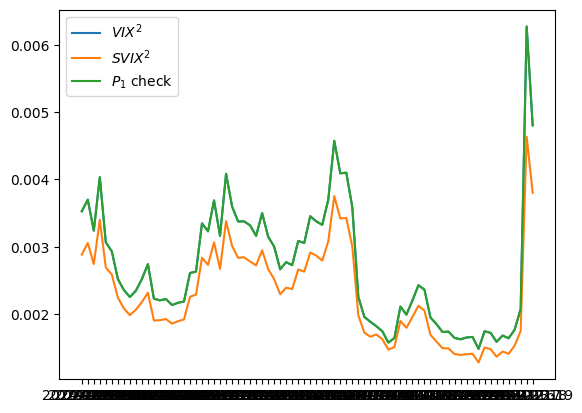

In [30]:
VIX_check=w_rep.join(term_rep_df,how='inner')
VIX_check['weighted_VIX^2']=VIX_check['VIX^2']*VIX_check['w']
VIX_check['weighted_SVIX^2']=VIX_check['SVIX^2']*VIX_check['w']
VIX_check['weighted_P1']=VIX_check['P1']*VIX_check['w']
VIX_check_2=VIX_check.groupby(VIX_check.index.get_level_values(0))[['weighted_VIX^2','weighted_SVIX^2','weighted_P1']].sum()
#VIX_check_2['VIX']=np.sqrt(VIX_check_2['weighted_VIX'].astype(float))*100
plt.plot(VIX_check_2.index,VIX_check_2['weighted_VIX^2'],label='$VIX^2$')
plt.plot(VIX_check_2.index,VIX_check_2['weighted_SVIX^2'],label='$SVIX^2$')
plt.plot(VIX_check_2.index,-2*VIX_check_2['weighted_P1'],label='$P_1$ check')
plt.legend()
plt.show()

CBOE_SKEW            1.0
SKEW_method2    0.850747
SKEW_method3     0.62963
SKEW_method4     0.40783
dtype: object

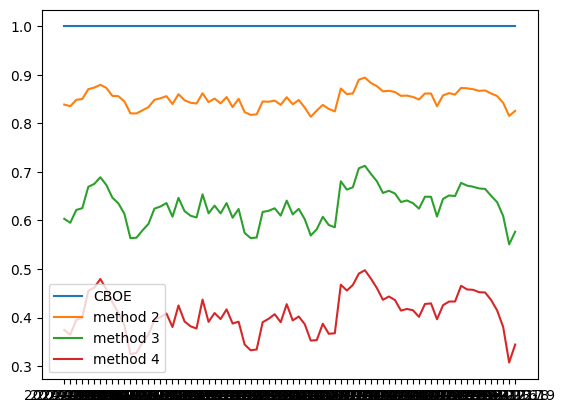

In [21]:
x=SKEW_rep_2[['CBOE_SKEW','SKEW_method2','SKEW_method3','SKEW_method4']]
x=x.copy()
x['SKEW_method2']=x['SKEW_method2']/x['CBOE_SKEW']
x['SKEW_method3']=x['SKEW_method3']/x['CBOE_SKEW']
x['SKEW_method4']=x['SKEW_method4']/x['CBOE_SKEW']
x['CBOE_SKEW']/=x['CBOE_SKEW']
display(x.mean())

plt.plot(x.index,x.CBOE_SKEW,label='CBOE')
plt.plot(x.index,x.SKEW_method2,label='method 2')
plt.plot(x.index,x.SKEW_method3,label='method 3') #simple skew
plt.plot(x.index,x.SKEW_method4,label='method 4') 
plt.legend()
plt.show()

In [225]:
#dont set returns lower than this
day_df.STRIKE_PRICE.min()/F-1
min(spotS_T)

2431.3777083777795

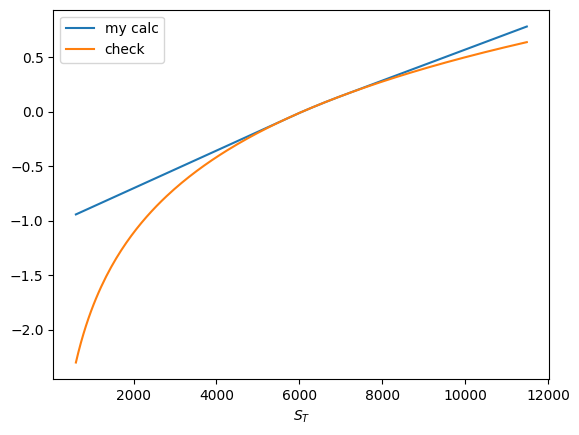

In [429]:
my_day='2024-12-17'
#my_day='2024-10-08'
day_df=vixmo_data_df[(vixmo_data_df.CALCULATION_DATE==my_day) &
                     (vixmo_data_df.TERM=='near') ]
F=day_df.FORWARD_PRICE.unique()[0]

#day_df_2=vixmo_data_df[(vixmo_data_df.CALCULATION_DATE==my_day) &
#                     (vixmo_data_df.TERM=='next') ]

#mins_30_days=30*60*24
#w=(day_df_2.MIN_TO_EXPIRE.unique()[0]-mins_30_days)
#w/=(day_df_2.MIN_TO_EXPIRE.unique()[0]-day_df.MIN_TO_EXPIRE.unique()[0])

def option_portfolio_payoffs(day_df,ST,truncation_condition):
    #truncation_condition=None

    F=day_df.FORWARD_PRICE.unique()[0]
    K0=day_df.K0_SELECTION.unique()[0]
    calls=day_df[day_df.STRIKE_PRICE>K0]
    puts=day_df[day_df.STRIKE_PRICE<K0]
    pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                            'CALL_PUT_FLAG':'P/C Avg', #put-call average
                            'midprice':day_df[(day_df.STRIKE_PRICE==K0)]['midprice'].mean(),
                            'INTEREST_RATE':day_df.INTEREST_RATE,
                            'YEARS_TO_EXPIRE':day_df.YEARS_TO_EXPIRE} ).head(1)
    opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
    #opt_portfolio=pd.concat([puts,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
    opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
    opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
    opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']

    #Truncating the portfolio
    opt_portfolio['moneyness_pct']=F/opt_portfolio['STRIKE_PRICE']-1
    opt_portfolio['z_moneyness']=(opt_portfolio['moneyness_pct']-opt_portfolio['moneyness_pct'].mean()) / opt_portfolio['moneyness_pct'].std() 

    opt_portfolio['option_payoff']=np.where(opt_portfolio['CALL_PUT_FLAG']=='C', 
                                            np.where(opt_portfolio.STRIKE_PRICE<=ST,ST-opt_portfolio.STRIKE_PRICE,0), 
                                            np.where(opt_portfolio.STRIKE_PRICE>=ST,opt_portfolio.STRIKE_PRICE-ST,0) )

    if truncation_condition:
        opt_portfolio=opt_portfolio.query(truncation_condition)

    r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
    #t=0
    #CBOE SKEW
    e1=-(1+np.log(F/K0)-(F/K0))
    e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
    e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
    p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
    p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2

    P1=( np.exp(r*t)*(opt_portfolio.midprice*p1_option_weight) ).sum()
    P1+=e1
    P2=( np.exp(r*t)*(opt_portfolio.midprice*p2_option_weight) ).sum()
    P2+=e2
    P3=( np.exp(r*t)*(opt_portfolio.midprice*p3_option_weight) ).sum()
    P3+=e3
    S=P3-3*P1*P2+2*P1**3
    sigma=np.sqrt(P2-P1**2)
    S/=sigma**3

    t=0
    P3_payoff = ( np.exp(r*0)*(opt_portfolio.option_payoff*p3_option_weight) ).sum()
    P2_payoff = ( np.exp(r*0)*(opt_portfolio.option_payoff*p2_option_weight) ).sum()
    P1_payoff = ( np.exp(r*0)*(opt_portfolio.option_payoff*p1_option_weight) ).sum()
    method1_payoff = (P3_payoff-3*P1_payoff*P2_payoff+2*P1_payoff**3) / sigma**3

    #METHOD2
    S_method2=6 * (np.exp(-P1-0.5*sigma**2)-1)
    S_method2/=sigma**3
    
    method2_payoff=(-6*P1_payoff - 3*P2_payoff) / sigma**3

    #METHOD3
    #"""
    #correction_term=(1/t)*(F/K0-1)**2
    VIX_opt_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    SVIX_opt_weight=2*opt_portfolio.dK/(F**2)
    VIX_square=( np.exp(r*t)*(opt_portfolio.option_payoff*VIX_opt_weight) ).sum()
    SVIX_square=( np.exp(r*t)*(opt_portfolio.option_payoff*SVIX_opt_weight) ).sum()
    #VIX_square+=correction_term
    #SVIX_square+=correction_term
    S_method3=3/2*(SVIX_square-VIX_square)
    S_method3/= sigma**3
    #"""
    method3_payoff = 3/2*(SVIX_square-VIX_square) / (sigma**3)


    #METHOD 4
    MartinSKEW_opt_weight=6*(opt_portfolio.STRIKE_PRICE-F)*opt_portfolio.dK/(F**3)
    MartinSKEW_opt_weight/=sigma**3
    S_method4=( np.exp(r*t)*(opt_portfolio.midprice*MartinSKEW_opt_weight) ).sum()
    
    method4_payoff = (np.exp(ST/F-1)-1)**3 / (sigma**3)

    #return sigma
    #return S,S_method2,S_method3,S_method4
    return VIX_square,SVIX_square,P1_payoff
    #return method1_payoff,method2_payoff,method3_payoff,method4_payoff
    #return VIX_square,P1_payoff-2*(ST/F-1)
    #return P1,P2,P3
    #return P1_payoff + (ST/F-1), np.log(ST/F)



spotS_T=np.array([F*(1+0.01*i) for i in range(-90,90)])
#spotS_T=np.array([F*(1+0.01*i) for i in range(-1_000,1_000)])
#spotS_T=np.where(spotS_T<=0,0,spotS_T)
#spotS_T=np.array([1+0.02*i for i in range(-20,20)])

#SKEW_payoff=( (np.log(spotS_T)-P1)/ np.sqrt(P2-P1**2) )**3

#truncation_condition=None
truncation_condition='abs(moneyness_pct<=0.05)'

#SKEW_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[0] for s in spotS_T] )
#SKEW_Method2_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[1] for s in spotS_T] )
#SKEW_Method3_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[2] for s in spotS_T] )
#SKEW_Method4_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[3] for s in spotS_T] )                            
#plt.plot(spotS_T,SKEW_payoff,label='CBOE SKEW',c='#069AF3')
#plt.plot(spotS_T,SKEW_Method2_payoff,label='Method2',c='orange')
#plt.plot(spotS_T,SKEW_Method3_payoff,label='Method3',c='#15B01A')
#plt.plot(spotS_T,SKEW_Method4_payoff,label='Method4',c='r')

VIX_square_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[0] for s in spotS_T] )
SVIX_square_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[1] for s in spotS_T] )
#P1_payoff=-2*np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[2] for s in spotS_T] )
P1_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[2] for s in spotS_T] )
#plt.plot(spotS_T,VIX_square_payoff,label='$VIX^2$')
#plt.plot(spotS_T,SVIX_square_payoff,label='$SVIX^2$')
plt.plot(spotS_T,(P1_payoff + (spotS_T/F-1) ),label='my calc')
plt.plot(spotS_T, np.log(spotS_T/F),label='check')
#plt.title('$VIX^2$ and $SVIX^2$ Payoffs')
plt.xlabel('$S_T$')

#sigma_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition) for s in spotS_T] )
#plt.plot(spotS_T,sigma_payoff,label='$\sigma$')

#verify 
#my_calc=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[0] for s in spotS_T] )
#check=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[1] for s in spotS_T] )
#plt.title('$P_2$ payoff')
#plt.plot(spotS_T,my_calc,label='my calc')
#plt.plot(spotS_T,check,label='check')

#P1_calc,P2_calc,P3_calc=option_portfolio_payoffs(day_df,100,truncation_condition)

plt.legend()
plt.show()

In [378]:
print(F)

np.where(np.diff(SKEW_payoff)<0)[0][-1]
print(spotS_T[np.where(np.diff(SKEW_payoff)<0)[0][-2]])
print(spotS_T[np.where(np.diff(SKEW_payoff)<0)[0][-1]])
print(spotS_T[np.where(np.diff(SKEW_payoff)<0)[0][-1]+1])

day_df.STRIKE_PRICE.describe()

6078.444270944448
3403.9287917288916
3464.713234438336
3525.4976771477805


count     404.000000
mean     5339.455446
std       959.165374
min      2400.000000
25%      4823.750000
50%      5552.500000
75%      6056.250000
max      7000.000000
Name: STRIKE_PRICE, dtype: float64

In [367]:
print(P1_calc)
print( day_df.P1.unique()[0] )
print('---------------')
print(P2_calc)
print( day_df.P2.unique()[0] )
print('---------------')
print(P3_calc)
print( day_df.P3.unique()[0] )

-0.0010682822257442226
-0.0010682822257442
---------------
0.0023741227542721194
0.0023741227542721
---------------
-0.0008503810036146084
-0.0008503810036146


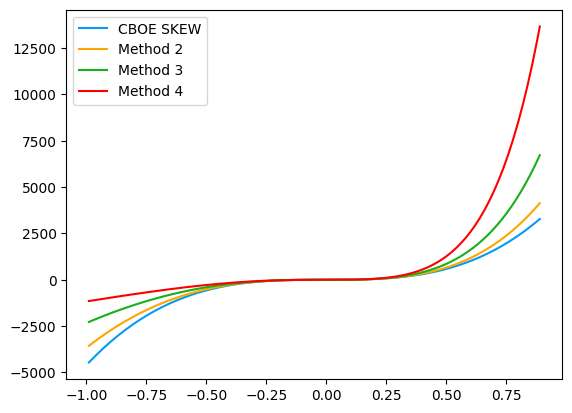

In [371]:
#cboeskew spreadhseet
P1=-0.00173
P2=0.003606
sigma=(P2-P1**2)**0.5
P3=-2.19656*sigma**3 - 2*P1**3 + 3*P1*P2

R=np.arange(-0.99,0.9,0.01)
#R=np.arange(-0.2,0.2,0.01)
CBOE_SKEW=((R-P1)/sigma)**3
METHOD_2=(6*np.exp(R) - 6-3*R**2-6*R) / (sigma**3)
METHOD_3=3/2*((np.exp(R)-1)**2 + 2*R-2*(np.exp(R)-1)) / (sigma**3)
METHOD_4=(np.exp(R)-1)**3 / (sigma**3)
plt.plot(R,CBOE_SKEW,label='CBOE SKEW',c='#069AF3')
plt.plot(R,METHOD_2,label='Method 2',c='orange')
plt.plot(R,METHOD_3,label='Method 3',c='#15B01A')
plt.plot(R,METHOD_4,label='Method 4',c='r')
plt.legend()
plt.show()


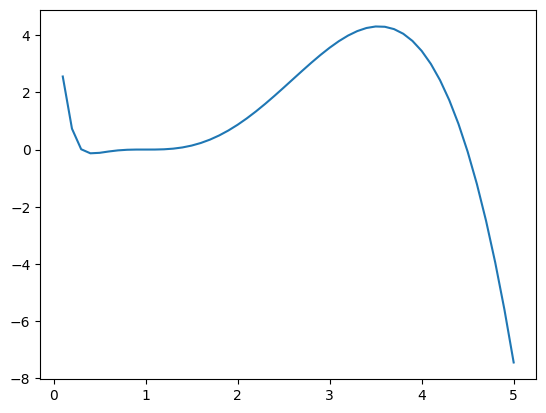

In [414]:
num_strikes=50
dK=0.1
K=np.arange(0.3,num_strikes*dK+dK,dK)
F=1
#print(K)

p1_weight=-dK/K**2
p2_weight=2*dK/K**2 * (1-np.log(K/F))
p3_weight=3*dK/K**2 * (2*np.log(K/F)-np.log(K/F)**2)

ST=3
def payoff_func(F,K,ST):
    return np.where(F>=K,np.maximum(K-ST,0), np.maximum(ST-K,0)  )  

ST=np.arange(0.1,5+dK,dK)
cboe_skew=[]
for s in ST:
    payoffs = payoff_func(F,K,s)
    p1_payoff,p2_payoff,p3_payoff=(payoffs*p1_weight).sum(),(payoffs*p2_weight).sum(),(payoffs*p3_weight).sum()
    cboe_skew.append(p3_payoff-3*p1_payoff*p2_payoff+2*p1_payoff**3)

plt.plot(ST,cboe_skew)
plt.show()

Bid-Ask Spread Analysis

In [242]:
def bid_ask_analysis(truncation_condition=None):

    def skew_weights_1(slice):
        mins_30_days=30*60*24
        slice1=slice[slice.TERM=='near']
        slice2=slice[slice.TERM=='next']
        w=(slice2.MIN_TO_EXPIRE.unique()[0]-mins_30_days)
        w/=(slice2.MIN_TO_EXPIRE.unique()[0]-slice1.MIN_TO_EXPIRE.unique()[0])
        return [w,1-w]

    def portfolio_constructors(slice):
        F=slice.FORWARD_PRICE.unique()[0]
        K0=slice.K0_SELECTION.unique()[0]
        calls=slice[slice.STRIKE_PRICE>K0]
        puts=slice[slice.STRIKE_PRICE<K0]
        pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                                'CALL_PUT_FLAG':'P/C Avg', #put-call average
                                'midprice':slice[(slice.STRIKE_PRICE==K0)]['midprice'].mean(),
                                'BID_PRICE':slice[(slice.STRIKE_PRICE==K0)]['BID_PRICE'].mean(),
                                'ASK_PRICE':slice[(slice.STRIKE_PRICE==K0)]['ASK_PRICE'].mean(),
                                'INTEREST_RATE':slice.INTEREST_RATE,
                                'YEARS_TO_EXPIRE':slice.YEARS_TO_EXPIRE} ).head(1)
        opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','BID_PRICE','ASK_PRICE','INTEREST_RATE','YEARS_TO_EXPIRE']]
        #opt_portfolio=pd.concat([puts,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
        opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
        opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
        opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']
        
        #Truncating the portfolio
        opt_portfolio['moneyness_pct']=F/opt_portfolio['STRIKE_PRICE']-1
        opt_portfolio['z_moneyness']=(opt_portfolio['moneyness_pct']-opt_portfolio['moneyness_pct'].mean()) / opt_portfolio['moneyness_pct'].std() 
        #opt_portfolio=opt_portfolio[ (abs(opt_portfolio.z_moneyness)<=2) ]
        #opt_portfolio=opt_portfolio[ (opt_portfolio.z_moneyness<=2) ]
        #opt_portfolio=opt_portfolio[ abs(opt_portfolio.moneyness_pct<=0.1) ]
        if truncation_condition:
            opt_portfolio=opt_portfolio.query(truncation_condition)
        #display(opt_portfolio)
        #print(5/0)

        r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
        
        #CBOE SKEW
        #"""
        def method_1(bid_or_ask):
            e1=-(1+np.log(F/K0)-(F/K0))
            e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
            e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
            p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
            p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
            p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
            p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
            p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2
            P1=( np.exp(r*t)*(opt_portfolio[f'{bid_or_ask}']*p1_option_weight) ).sum()
            P1+=e1
            P2=( np.exp(r*t)*(opt_portfolio[f'{bid_or_ask}']*p2_option_weight) ).sum()
            P2+=e2
            P3=( np.exp(r*t)*(opt_portfolio[f'{bid_or_ask}']*p3_option_weight) ).sum()
            P3+=e3
            S=P3-3*P1*P2+2*P1**3
            S/=(P2-P1**2)**(3/2)
            return S
        #"""
        
        #METHOD2
        #"""
        def method_2(bid_or_ask): 
            e1=-(1+np.log(F/K0)-(F/K0))
            e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
            p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
            p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
            p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
            P1=( np.exp(r*t)*(opt_portfolio[f'{bid_or_ask}']*p1_option_weight) ).sum()
            P1+=e1
            P2=( np.exp(r*t)*(opt_portfolio[f'{bid_or_ask}']*p2_option_weight) ).sum()
            P2+=e2
            sigma=np.sqrt(P2-P1**2)#**0.5
            #S_method2=6/sigma**3 * (np.exp(-P1-0.5*sigma**2)-1)
            S_method2=(-6*P1-3*P2)/sigma**3
            return S_method2
        #"""
        
        #METHOD3
        #"""
        def method_3(bid_or_ask):
            e1=-(1+np.log(F/K0)-(F/K0))
            e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
            p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
            p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
            p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
            P1=( np.exp(r*t)*(opt_portfolio[f'{bid_or_ask}']*p1_option_weight) ).sum()
            P1+=e1
            P2=( np.exp(r*t)*(opt_portfolio[f'{bid_or_ask}']*p2_option_weight) ).sum()
            P2+=e2
            correction_term=(1/t)*(F/K0-1)**2
            VIX_opt_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
            SVIX_opt_weight=2*opt_portfolio.dK/(F**2)
            VIX_square=( np.exp(r*t)*(opt_portfolio[f'{bid_or_ask}']*VIX_opt_weight) ).sum()
            SVIX_square=( np.exp(r*t)*(opt_portfolio[f'{bid_or_ask}']*SVIX_opt_weight) ).sum()
            #VIX_square+=correction_term
            #SVIX_square+=correction_term
            sigma=np.sqrt(P2-P1**2)#**0.5
            S_method3=3/2*(SVIX_square-VIX_square)/ sigma**3
            return S_method3
        #"""

        #METHOD 4
        #"""
        def method_4(bid_or_ask):
            e1=-(1+np.log(F/K0)-(F/K0))
            e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
            p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
            p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
            p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
            P1=( np.exp(r*t)*(opt_portfolio[f'{bid_or_ask}']*p1_option_weight) ).sum()
            P1+=e1
            P2=( np.exp(r*t)*(opt_portfolio[f'{bid_or_ask}']*p2_option_weight) ).sum()
            P2+=e2
            sigma=np.sqrt(P2-P1**2)#**0.5
            MartinSKEW_opt_weight=6*(opt_portfolio.STRIKE_PRICE-F)*opt_portfolio.dK/(F**3)
            MartinSKEW_opt_weight/=sigma**3
            S_method4=( np.exp(r*t)*(opt_portfolio.midprice*MartinSKEW_opt_weight) ).sum()
            return S_method4
        

        #"""
        bid_portfolio_method1, ask_portfolio_method1 = method_1('BID_PRICE'), method_1('ASK_PRICE')
        bid_portfolio_method2, ask_portfolio_method2 = method_2('BID_PRICE'), method_2('ASK_PRICE')
        bid_portfolio_method3, ask_portfolio_method3 = method_3('BID_PRICE'), method_3('ASK_PRICE')
        bid_portfolio_method4, ask_portfolio_method4 = method_4('BID_PRICE'), method_4('ASK_PRICE')
        return [bid_portfolio_method1, ask_portfolio_method1,
                bid_portfolio_method2, ask_portfolio_method2,
                bid_portfolio_method3, ask_portfolio_method3,
                bid_portfolio_method4, ask_portfolio_method4]
        #return [S,S_method2,S_method3,VIX_square,SVIX_square,P1,P2,S_method4] #.unique()[0]

    term_rep_df=pd.DataFrame(vixmo_data_df.groupby(['CALCULATION_DATE','TERM']).apply(portfolio_constructors),columns=['Replicates'])
    term_rep_df['bid_portfolio_method1']=term_rep_df['Replicates'].apply(lambda x:x[0])
    term_rep_df['ask_portfolio_method1']=term_rep_df['Replicates'].apply(lambda x:x[1])
    term_rep_df['bid_portfolio_method2']=term_rep_df['Replicates'].apply(lambda x:x[2])
    term_rep_df['ask_portfolio_method2']=term_rep_df['Replicates'].apply(lambda x:x[3])
    term_rep_df['bid_portfolio_method3']=term_rep_df['Replicates'].apply(lambda x:x[4])
    term_rep_df['ask_portfolio_method3']=term_rep_df['Replicates'].apply(lambda x:x[5])
    term_rep_df['bid_portfolio_method4']=term_rep_df['Replicates'].apply(lambda x:x[6])
    term_rep_df['ask_portfolio_method4']=term_rep_df['Replicates'].apply(lambda x:x[7])
    term_rep_df.drop(['Replicates'],axis=1,inplace=True)
    term_rep_df
    #"""
    w_rep=pd.DataFrame( vixmo_data_df.groupby(['CALCULATION_DATE']).apply(skew_weights_1) ,columns=['w'])
    w_rep['TERM']=[ ['near','next'] for i in w_rep.index]
    w_rep=w_rep.explode(['TERM','w'])
    w_rep.set_index('TERM', append=True, inplace=True)

    SKEW_rep_2=w_rep.join(term_rep_df,how='inner')
    SKEW_rep_2['weighted_bid_portfolio_method1']=SKEW_rep_2['bid_portfolio_method1']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_ask_portfolio_method1']=SKEW_rep_2['ask_portfolio_method1']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_bid_portfolio_method2']=SKEW_rep_2['bid_portfolio_method2']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_ask_portfolio_method2']=SKEW_rep_2['ask_portfolio_method2']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_bid_portfolio_method3']=SKEW_rep_2['bid_portfolio_method3']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_ask_portfolio_method3']=SKEW_rep_2['ask_portfolio_method3']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_bid_portfolio_method4']=SKEW_rep_2['bid_portfolio_method4']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_ask_portfolio_method4']=SKEW_rep_2['ask_portfolio_method4']*SKEW_rep_2['w']
    #taking away 100-10 scaling
    #SKEW_rep_2=100-10*SKEW_rep_2.groupby(SKEW_rep_2.index.get_level_values(0))[['weighted_S','weighted_S_method2','weighted_S_method3']].sum()
    SKEW_rep_2=SKEW_rep_2.groupby(SKEW_rep_2.index.get_level_values(0))[['weighted_bid_portfolio_method1','weighted_ask_portfolio_method1',
                                                                         'weighted_bid_portfolio_method2','weighted_ask_portfolio_method2',
                                                                         'weighted_bid_portfolio_method3','weighted_ask_portfolio_method3',
                                                                         'weighted_bid_portfolio_method4','weighted_ask_portfolio_method4']].sum()
    SKEW_rep_2.rename(columns={'weighted_bid_portfolio_method1':'method1_bid',
                            'weighted_ask_portfolio_method1':'method1_ask',
                            'weighted_bid_portfolio_method2':'method2_bid',
                            'weighted_ask_portfolio_method2': 'method2_ask',
                            'weighted_bid_portfolio_method3': 'method3_bid',
                            'weighted_ask_portfolio_method3':'method3_ask',
                            'weighted_bid_portfolio_method4': 'method4_bid',
                            'weighted_ask_portfolio_method4':'method4_ask'},inplace=True)
    #SKEW_rep_2[['CBOE_SKEW_chg','SKEW_method2_chg','SKEW_method3_chg','SKEW_method4_chg']]=SKEW_rep_2/SKEW_rep_2.shift(1)-1
    SKEW_rep_2#.to_csv('SKEW_formula_replciates.csv')
    #"""

    #return term_rep_df
    return SKEW_rep_2#,term_rep_df,w_rep

y=bid_ask_analysis(truncation_condition=None)
#cond='abs(moneyness_pct<=0.1)'
#cond='abs(moneyness_pct<=0.15)'
#display( index_computation(truncation_condition=cond) )

In [232]:
cond='abs(moneyness_pct<=0.1)'
y2=bid_ask_analysis(truncation_condition=cond)

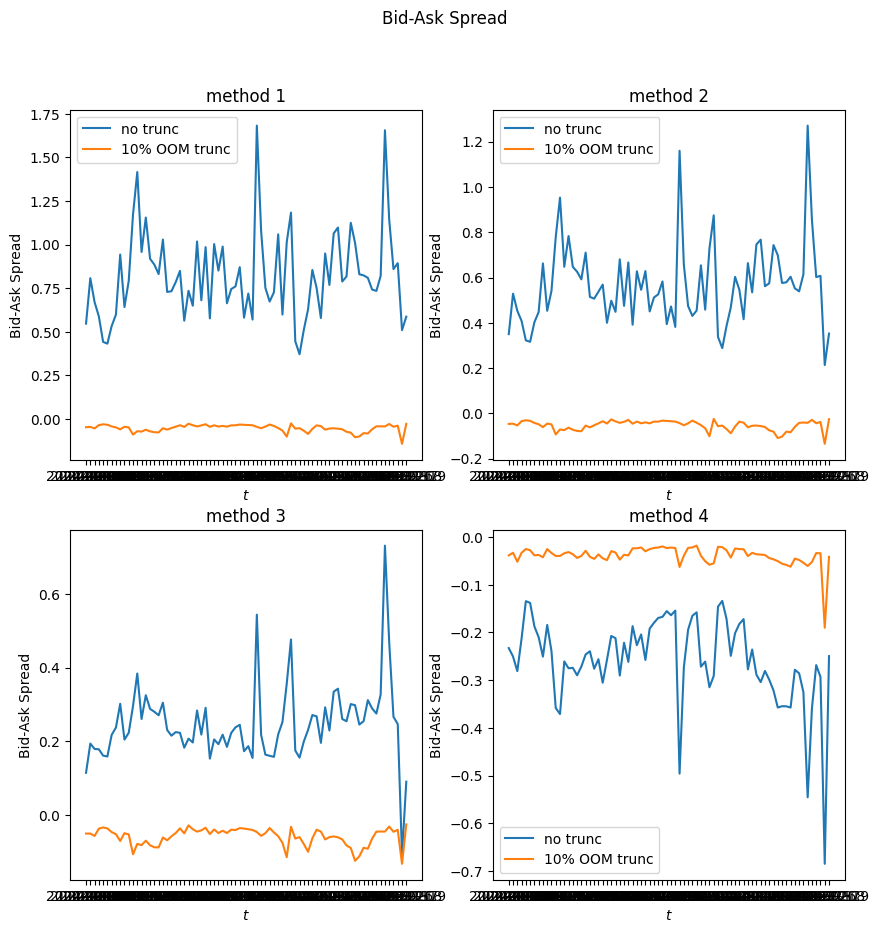

In [244]:
#pd.DataFrame(y)
y

fig= plt.figure(figsize=(10,10))
fig.suptitle('Bid-Ask Spread')


  
plt.subplot(2,2,1)
#plt.plot(y.index,y.method1_bid,c='r')
plt.plot(y.index,y.method1_bid-y.method1_ask,label='no trunc')
plt.plot(y2.index,y2.method1_bid-y2.method1_ask,label='10% OOM trunc')
plt.title(f'method 1')
plt.xlabel('$t$')
plt.ylabel('Bid-Ask Spread')
plt.legend()

plt.subplot(2,2,2)
#plt.plot(y.index,y.method2_bid,c='r')
plt.plot(y.index,y.method2_bid-y.method2_ask,label='no trunc')
plt.plot(y2.index,y2.method2_bid-y2.method2_ask,label='10% OOM trunc')
plt.title(f'method 2')
plt.xlabel('$t$')
plt.ylabel('Bid-Ask Spread')
plt.legend()

plt.subplot(2,2,3)
#plt.plot(y.index,y.method3_bid,c='r')
plt.plot(y.index,y.method3_bid-y.method3_ask,label='no trunc')
plt.plot(y2.index,y2.method3_bid-y2.method3_ask,label='10% OOM trunc')
plt.title(f'method 3')
plt.xlabel('$t$')
plt.ylabel('Bid-Ask Spread')


plt.subplot(2,2,4)
#plt.plot(y.index,y.method4_bid,c='r')
plt.plot(y.index,y.method4_bid-y.method4_ask,label='no trunc')
plt.plot(y2.index,y2.method4_bid-y2.method4_ask,label='10% OOM trunc')
plt.title(f'method 4')
plt.xlabel('$t$')
plt.ylabel('Bid-Ask Spread')

plt.legend()
plt.show()

In [243]:
y

,method1_bid,method1_ask,method2_bid,method2_ask,method3_bid,method3_ask,method4_bid,method4_ask
CALCULATION_DATE,,,,,,,,
2024-09-03,-6.070485,-6.617257,-5.187261,-5.537158,-3.776188,-3.890658,-2.499538,-2.26675
2024-09-04,-5.65986,-6.467536,-4.844909,-5.373662,-3.521091,-3.714812,-2.351062,-2.10051
2024-09-05,-5.311395,-5.9817,-4.606241,-5.058994,-3.428685,-3.607796,-2.389576,-2.108428
2024-09-06,-4.585634,-5.174141,-3.98903,-4.397194,-2.967953,-3.146197,-2.068829,-1.856081
2024-09-09,-3.803319,-4.245569,-3.380596,-3.702918,-2.616241,-2.777277,-1.904572,-1.770166
...,...,...,...,...,...,...,...,...
2024-12-13,-6.378681,-7.522106,-5.591984,-6.445901,-4.296664,-4.765043,-3.23793,-2.878983
2024-12-16,-6.225673,-7.085064,-5.431191,-6.033147,-4.118013,-4.384177,-2.907968,-2.639514
2024-12-17,-6.830884,-7.724535,-5.862235,-6.469556,-4.319397,-4.566008,-2.933275,-2.640029


In [183]:
vixmo_data_df.columns

Index(['SYMBOL_ID', 'INDEX_ID', 'CALCULATION_TIME', 'RESULT', 'RAW_RESULT',
       'TERM', 'INTEREST_RATE', 'K0_SELECTION', 'FORWARD_PRICE',
       'MIN_TO_EXPIRE', 'INSTRUMENT_ID', 'SYMBOL', 'EXPIRE_DATE',
       'STRIKE_PRICE', 'CALL_PUT_FLAG', 'BID_PRICE', 'ASK_PRICE',
       'STRIKE_PRICE_WEIGHT', 'STRIKE_PRICE_CONTRIBUTION', 'TRADE_DT',
       'HEALTHY', 'PREV_VALUE', 'midprice', 'YEARS_TO_EXPIRE', 'p1_contr',
       'p2_contr', 'p3_contr', 'series_count', 'P1', 'P2', 'P3', 'S',
       'CALCULATION_DATE'],
      dtype='object')

Reconciling sigma

5725.801103639765
0.049373239973268195
0.044084909250467104
0.039148147898833335
0.03455190935771903
0.030286539545359942
0.026344363786006852
0.022712538047989582
0.019384624920027144
0.01635070374827672
0.01360229228178893
0.011131207849911614
0.008929036414285555
0.0069884672715298255
0.005301192089807755
0.0038606805017366006
0.0026589130510537595
0.0016895514807357252
0.000945360834196436
0.00042001689087305686
0.00010699574640468878
0.0
9.315046132484845e-05
0.00038018798153281237
0.0008558180695755488
0.0015138752137224866
0.0023494597396499723
0.0033567200904593875
0.004530829827256429
0.0058669414581199
0.007358965881447406
0.009003249271356371
0.01079482302751059
0.012728591486445267
0.014802129195699728
0.017006850629528728
0.01934367602253254
0.021807682946998263
0.02438354093037559
0.027074853631129516
0.029763270567787027


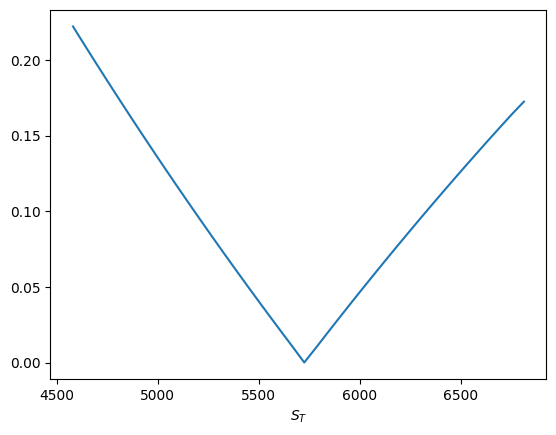

[0.22220090002803364,
 0.2099640665696564,
 0.19785890907116954,
 0.18588143898119314,
 0.1740302834145826,
 0.1623094691815818,
 0.15070679496290001,
 0.13922867851138696,
 0.12786987036935918,
 0.11662886555989872,
 0.10550453947537809,
 0.09449357869339882,
 0.08359705300744653,
 0.0728092857388929,
 0.06213437455818317,
 0.051564649238153064,
 0.04110415405692867,
 0.03074672070638487,
 0.020494313622882246,
 0.010343874825455342,
 0.0,
 0.009651448664570954,
 0.019498409718046558,
 0.029254368384491723,
 0.038908549365434926,
 0.04847122589382254,
 0.057937208169356824,
 0.06731143905203951,
 0.0765959624139543,
 0.08578441514312146,
 0.09488545342335869,
 0.10389813774803949,
 0.11282105958749575,
 0.1216640012316697,
 0.13041031642293,
 0.1390815445072873,
 0.14767424605190393,
 0.15615230043254436,
 0.1645443819494592,
 0.17252034827169527]

In [182]:
#ST=100
my_day='2024-11-04'
day_df=vixmo_data_df[(vixmo_data_df.CALCULATION_DATE==my_day) &
                    (vixmo_data_df.TERM=='near') ]
F=day_df.FORWARD_PRICE.unique()[0]

def calcultae_sigma(day_df,ST):

    F=day_df.FORWARD_PRICE.unique()[0]
    K0=day_df.K0_SELECTION.unique()[0]
    calls=day_df[day_df.STRIKE_PRICE>K0]
    puts=day_df[day_df.STRIKE_PRICE<K0]
    pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                            'CALL_PUT_FLAG':'P/C Avg', #put-call average
                            'midprice':day_df[(day_df.STRIKE_PRICE==K0)]['midprice'].mean(),
                            'INTEREST_RATE':day_df.INTEREST_RATE,
                            'YEARS_TO_EXPIRE':day_df.YEARS_TO_EXPIRE} ).head(1)
    opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
    #opt_portfolio=pd.concat([puts,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
    opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
    opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
    opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']

    opt_portfolio['option_payoff']=np.where(opt_portfolio['CALL_PUT_FLAG']=='C', 
                                                np.where(opt_portfolio.STRIKE_PRICE<=ST,ST-opt_portfolio.STRIKE_PRICE,0), 
                                                np.where(opt_portfolio.STRIKE_PRICE>=ST,opt_portfolio.STRIKE_PRICE-ST,0) )

    r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
    t=0
    e1=-(1+np.log(F/K0)-(F/K0))
    e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
    e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
    p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
    p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2

    P1=( np.exp(r*t)*(opt_portfolio.option_payoff*p1_option_weight) ).sum()
    #P1+=e1
    P2=( np.exp(r*t)*(opt_portfolio.option_payoff*p2_option_weight) ).sum()
    #P2+=e2
    sigma=np.sqrt(P2-P1**2)#**0.5
    print(P2-P1**2)
    #if P2-P1**2<0:
    #    sigma=0
    #sigma=(P2-P1**2)
    #P3=( np.exp(r*t)*(opt_portfolio.midprice*p3_option_weight) ).sum()
    #P3+=e3
    #S=P3-3*P1*P2+2*P1**3
    #S/=(P2-P1**2)**(3/2)
    #if ST==F:
    #    print(P2-P1**2)
    return sigma


print(F)
spotS_T=np.array([F*(1+0.01*i) for i in range(-20,20)])
sigmas=[calcultae_sigma(day_df,s) for s in spotS_T]
plt.xlabel('$S_T$')
plt.plot(spotS_T,sigmas)
plt.show()

sigmas


In [441]:


def quality_check(slice):
    truncation_condition=None
    F=slice.FORWARD_PRICE.unique()[0]
    K0=slice.K0_SELECTION.unique()[0]
    calls=slice[slice.STRIKE_PRICE>K0]
    puts=slice[slice.STRIKE_PRICE<K0]
    pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                            'CALL_PUT_FLAG':'P/C Avg', #put-call average
                            'midprice':slice[(slice.STRIKE_PRICE==K0)]['midprice'].mean(),
                            'INTEREST_RATE':slice.INTEREST_RATE,
                            'YEARS_TO_EXPIRE':slice.YEARS_TO_EXPIRE} ).head(1)
    opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
    #opt_portfolio=pd.concat([puts,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
    opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
    opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
    opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']

    #Truncating the portfolio
    opt_portfolio['moneyness_pct']=F/opt_portfolio['STRIKE_PRICE']-1
    opt_portfolio['z_moneyness']=(opt_portfolio['moneyness_pct']-opt_portfolio['moneyness_pct'].mean()) / opt_portfolio['moneyness_pct'].std() 

    if truncation_condition:
        opt_portfolio=opt_portfolio.query(truncation_condition)

    r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
    #CBOE SKEW
    e1=-(1+np.log(F/K0)-(F/K0))
    e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
    e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
    p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
    p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2

    P1=( np.exp(r*t)*(opt_portfolio.midprice*p1_option_weight) ).sum()
    P1+=e1
    P2=( np.exp(r*t)*(opt_portfolio.midprice*p2_option_weight) ).sum()
    P2+=e2
    P3=( np.exp(r*t)*(opt_portfolio.midprice*p3_option_weight) ).sum()
    P3+=e3
    S=P3-3*P1*P2+2*P1**3
    sigma=np.sqrt(P2-P1**2)
    S/=sigma**3

    return [P1,P2,P3,S]

test_df=pd.DataFrame(vixmo_data_df.groupby(['CALCULATION_DATE','TERM']).apply(quality_check),columns=['Replicates'])
test_df['P1_UMD']=test_df['Replicates'].apply(lambda x:x[0])
test_df['P2_UMD']=test_df['Replicates'].apply(lambda x:x[1])
test_df['P3_UMD']=test_df['Replicates'].apply(lambda x:x[2])
test_df['S_UMD']=test_df['Replicates'].apply(lambda x:x[3])
test_df.drop(['Replicates'],axis=1,inplace=True)
#display(test_df)

cboe_df=pd.DataFrame(vixmo_data_df.groupby(['CALCULATION_DATE','TERM'])[['P1','P2','P3','S']].mean())
cboe_df.columns=[i+'_CBOE' for i in cboe_df.columns]
cboe_df

merged_df=test_df.join(cboe_df,how='inner')
merged_df['P1_error']=abs(merged_df['P1_UMD']-merged_df['P1_CBOE'])
merged_df['P2_error']=abs(merged_df['P2_UMD']-merged_df['P2_CBOE'])
merged_df['P3_error']=abs(merged_df['P3_UMD']-merged_df['P3_CBOE'])
merged_df['S_error']=abs(merged_df['S_UMD']-merged_df['S_CBOE'])
merged_df[['P1_error','P2_error','P3_error','S_error']].describe()

,P1_error,P2_error,P3_error,S_error
count,1.520000e+02,1.520000e+02,1.520000e+02,1.520000e+02
mean,4.993348e-17,4.826590e-17,4.776503e-17,1.358562e-15
std,2.770838e-17,2.947796e-17,3.033388e-17,2.016850e-15
min,4.336809e-19,2.168404e-19,0.000000e+00,0.000000e+00
25%,2.705084e-17,2.059984e-17,2.141299e-17,0.000000e+00
50%,5.213657e-17,4.683753e-17,4.912791e-17,8.881784e-16
75%,7.299391e-17,7.155734e-17,7.239760e-17,1.776357e-15
max,9.931292e-17,9.887924e-17,9.887924e-17,1.865175e-14
